In [1]:
from env import ImgRouterEvalEnv
from lightning_lite.utilities.seed import seed_everything
from bandit_algo import BanditAlgorithm
from preference_estimator import (
    EmpiricalEstimator,
    NeuralEstimator,
    RecurrentNeuralEstimator,
    RecurrentNeuralEstimatorV0,
    DummyEstimator,
)
from exploration_strategy import (
    PerArmExploration,
    UniformEpsilonExploration,
    RandomRouting,
)
import numpy as np

import matplotlib.pyplot as plt
import torch
plt.style.use("fivethirtyeight")
import os
from copy import deepcopy
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":16:8"

from rich.console import Console
console = Console()

In [2]:
num_tasks = 3
num_cls = 10
# reduce_fator = 2
reduce_fator = 8
num_candidates = 256
# num_candidates = 512
num_slates = num_candidates // reduce_fator
use_img = True
use_img = False

# max_steps = 200
max_steps = 800
num_seeds = 1

estimator_cfg = {
        "reset_period": 10,
    }


explore_cfg = {
    "epsilon": 2.0,
    "min_epsilon": 0.01,
    "decay_factor": 0.9,
    "exploit_factor": 3.0,
}

cfg = {
        "num_candidates": num_candidates,
        "max_steps": max_steps,
        # "evaluate_strategy": "leave_one_out",
        # "evaluate_strategy": "each_one",
        "evaluate_strategy": "uniform",
        "use_img": use_img,
    }

In [3]:
def main(algo, env):
    obs = env.reset()
    # print("initial obs:", obs)
    done = False
    step_rewards = []
    pred_losses = []
    model_perfs = [env.model.test_acc()]
    while not done:
        action = algo.predict(obs)
        next_obs, reward, done, info = env.step(action)
        algo.update_estimator(obs, action, info["rewards"])
        obs = next_obs
        step_rewards.append(reward)
        # pred_loss = (algo.estimator.Q - env.Q) ** 2
        # pred_losses.append(pred_loss)
        model_perfs.append(env.model.test_acc())

    print("current samples after training:")
    print(env.current_samples)
    # routed_data = env.current_samples - existing_samples
    # routed_data = env.current_samples
    # print("routed data:")
    # print(routed_data)
    print("reward:", np.mean(step_rewards))
    return step_rewards, model_perfs


In [4]:
def get_algos():
    # algos = [(DummyEstimator, RandomRouting)]
    algos = []

    estimators = [EmpiricalEstimator, 
                    NeuralEstimator,
                    RecurrentNeuralEstimatorV0,]
    estimators = [EmpiricalEstimator, ]
                    # NeuralEstimator,
                    # RecurrentNeuralEstimatorV0,]
    algos += [
        (estimator,
        UniformEpsilonExploration) for estimator in estimators]
    
    
    return algos

In [5]:


torch.use_deterministic_algorithms(True)
estimator_step_rewards = {}
estimator_model_perfs = {}
estimator_routed_samples = {}
algos = get_algos()

for est_cls, explore_cls in algos:
    if use_img and est_cls == EmpiricalEstimator:
        continue
    step_rewards, model_perfs, routed_samples = [], [], []
    console.print(f"Estimator: {est_cls.__name__}", style="red")
    for seed in range(num_seeds):
        console.print(f"Seed: {seed}", style="blue")
        seed_everything(seed)
        env = ImgRouterEvalEnv(cfg)
        # skip EmpiricalEstimator
        algo = BanditAlgorithm(
            est_cls(num_tasks, num_cls, use_img=use_img, cfg=estimator_cfg),
            explore_cls(num_tasks, num_cls, num_slates, cfg=explore_cfg),
        )
        step_rewards_seed, model_perfs_seed = main(algo,env)
        routed_samples_seed = deepcopy(env.routed_samples_per_time)
        step_rewards.append(step_rewards_seed)
        model_perfs.append(model_perfs_seed)
        routed_samples.append(routed_samples_seed)
        print("\n\n")

    
    estimator_step_rewards[algo.estimator.__class__.__name__] = np.array(step_rewards)
    estimator_model_perfs[algo.estimator.__class__.__name__] = np.array(model_perfs)
    estimator_routed_samples[algo.estimator.__class__.__name__] = np.array(routed_samples)

Estimator: EmpiricalEstimator

Seed: 0

Global seed set to 0


epsilon 2.0, min_epislon 0.01, decay_factor 0.9, exploit_factor 3.0
MNIST num parameters: 15298
step 0 epsilon 2.0
routed_batch_z (tensor([0, 1, 2]), tensor([12, 10, 10]))
delta:
[[ 0.          0.02451468  0.00817156  0.          0.          0.02451468
   0.00817156  0.01634312  0.00817156  0.00817156]
 [ 0.         -0.00894117 -0.00447059 -0.00894117 -0.00447059 -0.00894117
  -0.00447059  0.          0.         -0.00447059]
 [ 0.          0.         -0.00344872 -0.00344872 -0.00689745  0.
  -0.00344872 -0.00344872 -0.00689745 -0.00689745]]
step 1 epsilon 1.8
routed_batch_z (tensor([0, 1, 2]), tensor([11, 13,  8]))
delta:
[[0.         0.01001716 0.02003431 0.         0.03005147 0.
  0.01001716 0.         0.01001716 0.03005147]
 [0.00157619 0.00472856 0.00315237 0.         0.00315237 0.00472856
  0.         0.         0.00315237 0.        ]
 [0.         0.00878763 0.00878763 0.         0.00439382 0.00439382
  0.         0.         0.00878763 0.        ]]
step 2 epsilon 1.62
routed_batch

KeyboardInterrupt: 

In [ ]:
env.current_samples

In [ ]:
estimator_routed_samples['EmpiricalEstimator'][0, :].sum(axis=(0,2))

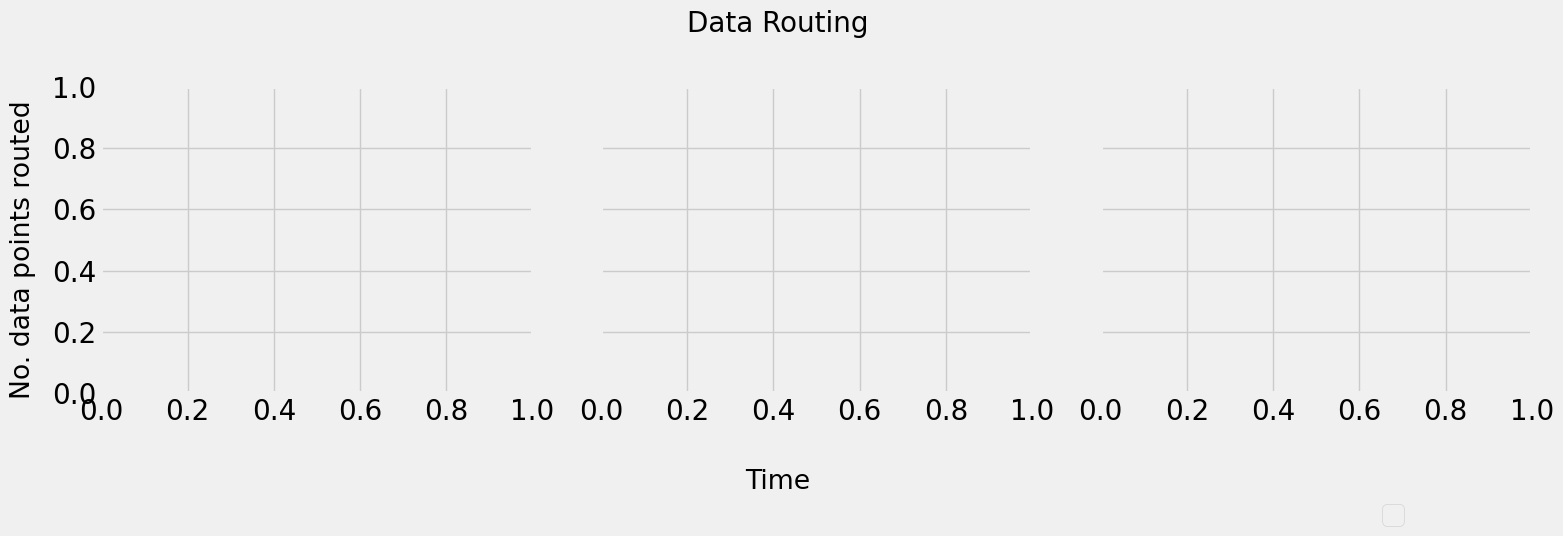

In [12]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(16, 5))

for task in range(3):
    for estimator_name, routed_samples in estimator_routed_samples.items():
        routed_samples_task = routed_samples.sum(axis=-1)[:, :, task]  # sum over classes
        ax[task].plot(routed_samples_task.mean(axis=0), label=estimator_name)
        std = routed_samples_task.std(axis=0)
        ax[task].fill_between(
            np.arange(len(std)),
            routed_samples_task.mean(axis=0) - std,
            routed_samples_task.mean(axis=0) + std,
            alpha=0.2,
        )
        ax[task].set_title(f"Task {task}")
        print(estimator_name, "task:", task, "routed_samples:", np.mean(routed_samples_task))

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', ncol=3, fontsize=20, bbox_to_anchor=(0.9, -0.08));
fig.suptitle("Data Routing", fontsize=20)
plt.rcParams.update({'font.size': 16})
fig.supxlabel("Time")
fig.supylabel("No. data points routed")
plt.tight_layout();

In [ ]:
plt.title("Step Reward (Uniform)")
plt.ylabel("Reward")
plt.xlabel("Step")
for estimator_name, step_rewards in estimator_step_rewards.items():
    plt.plot(step_rewards.mean(axis=0), label=estimator_name)
    std = step_rewards.std(axis=0)
    plt.fill_between(
        np.arange(len(std)),
        step_rewards.mean(axis=0) - std,
        step_rewards.mean(axis=0) + std,
        alpha=0.2,
    )
    print(estimator_name, np.mean(step_rewards))
plt.legend(loc="best");
plt.tight_layout()

In [ ]:
plt.title("MNIST Model Accuracy (Uniform)")
plt.ylabel("Accuracy")
plt.xlabel("Step")
for estimator_name, model_perfs in estimator_model_perfs.items():
    plt.plot(model_perfs.mean(axis=0), label=estimator_name)
    std = model_perfs.std(axis=0)
    plt.fill_between(
        np.arange(len(std)),
        model_perfs.mean(axis=0) - std,
        model_perfs.mean(axis=0) + std,
        alpha=0.2,
    )
    print(estimator_name, np.mean(model_perfs))
plt.legend(loc="best");
plt.tight_layout()